<a href="https://colab.research.google.com/github/fouad89/nlp-tutorial/blob/main/classification_using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import gensim.downloader as api
import nltk


In [3]:
data_path = '/content/drive/MyDrive/Datasets/bbc-text.csv'
def read_data(data_path):
    return pd.read_csv(data_path)

def get_data_info(df):
    print(df.info())
    print(f'Description: \n{df.describe()}')
    print()
    print(f'Number of rows {df.shape[0]}, Number of Columns: {df.shape[1]}')
    print()
    print(f'Number of Null values {df.isnull().sum()}')
    print()
    print(f'Columns: {df.columns}')

In [4]:
df = read_data(data_path)
get_data_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB
None
Description: 
       category                                               text
count      2225                                               2225
unique        5                                               2126
top       sport  kennedy questions trust of blair lib dem leade...
freq        511                                                  2

Number of rows 2225, Number of Columns: 2

Number of Null values category    0
text        0
dtype: int64

Columns: Index(['category', 'text'], dtype='object')


# Preparing Input Data

In [15]:
X = df['text']
y = LabelBinarizer().fit_transform(df['category'])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, 
                                                    stratify=df.category)


print(f'Shape of X_train is: { X_train.shape}')
print(f'Shape of X_test is: { X_test.shape}')
print(f'Shape of y_train is: { y_train.shape}')
print(f'Shape of y_test is: { y_test.shape}')

Shape of X_train is: (1668,)
Shape of X_test is: (557,)
Shape of y_train is: (1668, 5)
Shape of y_test is: (557, 5)


In [20]:
MAX_LEN = 200

tokenizer = Tokenizer(num_words=15000, lower=True, oov_token='<OOV>')
# tokenizer fit on full corpus
tokenizer.fit_on_texts(df['text'])
vocab = tokenizer.word_index
reversed_vocab = {v:k for k,v in vocab.items()}
# creating sequences
train_seq = tokenizer.texts_to_sequences(X_train)
test_seq = tokenizer.texts_to_sequences(X_test)

# padding sequences to keep the same length
train_padded = pad_sequences(train_seq, maxlen=MAX_LEN)
test_padded = pad_sequences(test_seq, maxlen=MAX_LEN)

# Word2Vec

In [23]:
w2v = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [28]:
max_words =15000
emb_matrix=np.zeros((max_words+1, 300))
for i in range(max_words):
    w = reversed_vocab[i+1]
    if w in w2v:
        emb_matrix[i+1,:] = w2v[w]
emb_size = emb_matrix.shape[1]

In [30]:
emb_matrix.shape

(15001, 300)

In [32]:
train_padded[0,:].shape

(200,)

## Building the model

In [45]:
input_ = Input(shape=train_padded[0,:].shape, name='input')
# embeddings
x = Embedding(input_dim=max_words+1,
              output_dim=emb_size,
              weights=[emb_matrix],
              trainable=False,
              name='embedding'
              )(input_)

x = Bidirectional(LSTM(15, dropout=0.2), name='bidirectional')(x)
x = Dropout(0.2, name='dropout')(x)
x = Dense(64, activation='relu', name='dense_hidden')(x)
# output
output = Dense(5, activation='softmax', name='output')(x)
model = Model(input_, output)
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-3, beta_1=0.9)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 300)          4500300   
                                                                 
 bidirectional (Bidirectiona  (None, 30)               37920     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense_hidden (Dense)        (None, 64)                1984      
                                                                 
 output (Dense)              (None, 5)                 325       
                                                           

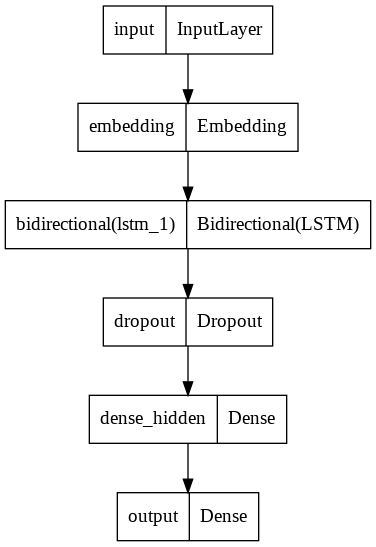

In [41]:
plot_model(model)

In [46]:
history = model.fit(train_padded, y_train, batch_size=64,
                    validation_data=(test_padded, y_test), epochs=10)

Epoch 1/10
27/27 [==============================] - 20s 460ms/step - loss: 1.5401 - accuracy: 0.3447 - val_loss: 1.2794 - val_accuracy: 0.4991
Epoch 2/10
27/27 [==============================] - 11s 396ms/step - loss: 0.9611 - accuracy: 0.6355 - val_loss: 0.8148 - val_accuracy: 0.7056
Epoch 3/10
27/27 [==============================] - 11s 400ms/step - loss: 0.7976 - accuracy: 0.7350 - val_loss: 0.6234 - val_accuracy: 0.8025
Epoch 4/10
27/27 [==============================] - 11s 393ms/step - loss: 0.5024 - accuracy: 0.8447 - val_loss: 0.3773 - val_accuracy: 0.8815
Epoch 5/10
27/27 [==============================] - 11s 394ms/step - loss: 0.4171 - accuracy: 0.8681 - val_loss: 0.4012 - val_accuracy: 0.8689
Epoch 6/10
27/27 [==============================] - 10s 383ms/step - loss: 0.4205 - accuracy: 0.8675 - val_loss: 0.3945 - val_accuracy: 0.8941
Epoch 7/10
27/27 [==============================] - 12s 452ms/step - loss: 0.3061 - accuracy: 0.9071 - val_loss: 0.3794 - val_accuracy: 0.8887